In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#hide
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
#hide
from nbdev_c19_synthesis.c19_synthesis.core import *

In [ ]:
#hide
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation
from scipy import ndimage

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## How to use

Fill me in please! Don't forget code examples:

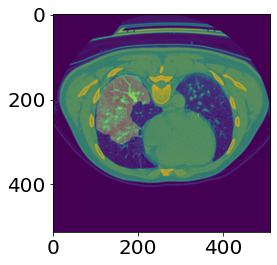

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'

ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
plt.imshow(ct[...,100])
plt.imshow(ct_mask[...,100], alpha=.3);

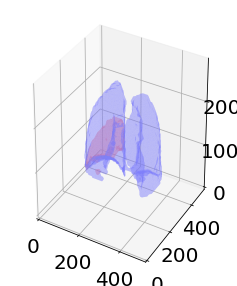

In [ ]:
#@title plot ct
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
a=np.moveaxis(largest_component,2,0)
b=np.moveaxis(ct_mask_small,2,0)
plot_3d_2(a, b, .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

118
2


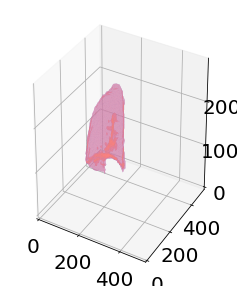

In [ ]:
#@title erode masks to separate the two lungs and get indiviual masks {vertical-output: true}
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
print(nr)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
print(nr)
plot_3d_2(np.moveaxis(two_lungs==2,2,0), np.moveaxis(two_lungs==2,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

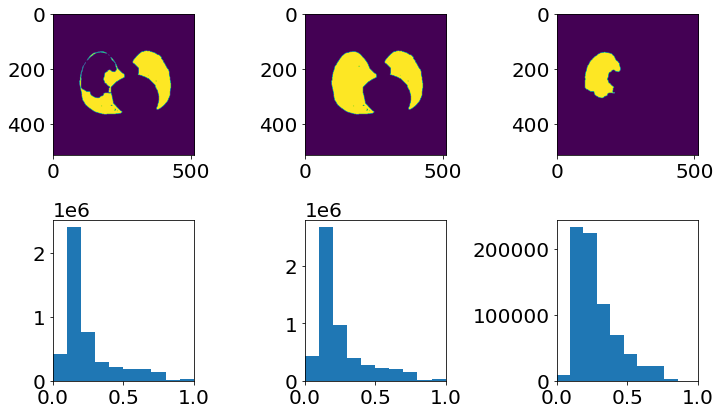

In [ ]:
#@title get masks {vertical-output: true}
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask
target_mask2 = ~bkgd
target_mask3 = ct_mask_small.astype(bool)
# ========
SLICE=100
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax[0,0].imshow(target_mask[...,SLICE])
ax[1,0].hist(ct_small[np.where(target_mask!=0)].flatten()); ax[1,0].set_xlim([0,1]);
ax[0,1].imshow(target_mask2[...,SLICE])
ax[1,1].hist(ct_small[np.where(target_mask2!=0)].flatten()); ax[1,1].set_xlim([0,1]);
ax[0,2].imshow(target_mask3[...,SLICE])
ax[1,2].hist(ct_small[np.where(target_mask3!=0)].flatten()); ax[1,2].set_xlim([0,1]);
plt.tight_layout()

26 141 364 97 241 64 165


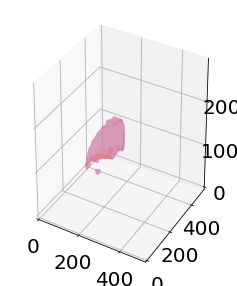

In [ ]:
#@title label {vertical-output: true}
lab, nr_ = label(target_mask3)
y_max, y_min, x_max, x_min, z_max, z_min = get_min_max(target_mask3)
print(nr_, y_max, y_min, x_max, x_min, z_max, z_min)
plot_3d_2(np.moveaxis(target_mask3,2,0), np.moveaxis(target_mask3,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

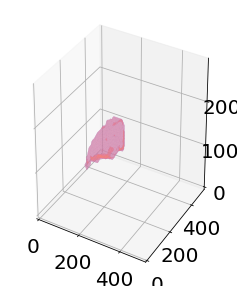

1 339 141 241 97 165 64


In [ ]:
#@title get only one big lesion {vertical-output: true}

lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
plot_3d_2(np.moveaxis(one_big_lesion,2,0), np.moveaxis(one_big_lesion,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
print(nr_,y_max_lesion, y_min_lesion, x_max_lesion, x_min_lesion, z_max_lesion, z_min_lesion)

141 339 97 241 64 165 2
140 362 97 265 41 245


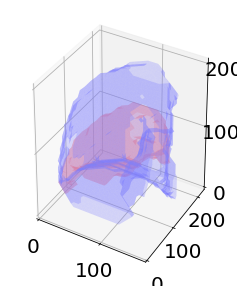

In [ ]:
#@title get lung that contains lesion {vertical-output: true}
for i in np.arange(1,3):
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    print(y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion, i)
    print(y_min, y_max, x_min, x_max, z_min, z_max)
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
plot_3d_2(np.moveaxis(lung_inpaint>0,2,0), np.moveaxis(lung_one_big_lesion,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

In [ ]:
#@title add zeros outsides the lungs to the mask until multiple of 32 {vertical-output: true}
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
print(np.unique(mask_inpain))
print(np.shape(mask_inpain), np.shape(img), np.shape(lung_one_lesion))
fig, ax = plt.subplots(1,3, figsize=(9,6))
ax[0].imshow(mask_inpain[...,100])
ax[1].imshow(img[...,100])
ax[2].imshow(lung_one_lesion[...,100])

NameError: ignored